_В домашнем задании, будем обучать разные алгоритмы машинного обучения. Для этого, нужно предварительно зафиксировать схему валидации решения (можете выбрать любую, которую знаете). Выбранную схему валидации нужно использовать во всех задачах этого домашнего задания. Метрика качества_ - __ROC AUC__, _целевая переменная_ - __isFraud.__

__Ссылка на наборы данных:__ https://drive.google.com/file/d/1gMEVl47pIoV1-AseB9doQ6DZNJrY3NkW/view?usp=sharing

__Задание 1:__ _отобрать только числовые признаки и обучить модель XGBoost с параметром booster = gbtree. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно)._

In [1]:
# !conda install -c anaconda py-xgboost -y 1>nul
# !conda install lightgbm -y 1>nul
# !conda install catboost -y 1>nul

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

%matplotlib inline

In [3]:
train = pd.read_csv("data/assignment_2_train.csv")
test = pd.read_csv("data/assignment_2_test.csv")

print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))

train.shape = 180000 rows, 394 cols
test.shape = 100001 rows, 394 cols


In [4]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
target = "isFraud"
numerical_features = train.select_dtypes(include=[np.number]).drop(columns=target).columns

In [6]:
train[target].unique()

array([0, 1], dtype=int64)

In [7]:
train_t, train_v = train_test_split(train, train_size=0.8, random_state=27)

In [8]:
params_xg = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": -1,
    "seed": 27
}

In [9]:
dtrain = xgb.DMatrix(data=train_t[numerical_features], label=train_t[target])
dvalid = xgb.DMatrix(data=train_v[numerical_features], label=train_v[target])
dtest = xgb.DMatrix(data=test[numerical_features])

In [10]:
model_xgb = xgb.train(
    params=params_xg,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=10,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=20,
    maximize=True,
)

[0]	train-auc:0.651834	valid-auc:0.642258
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 10 rounds.
[20]	train-auc:0.840269	valid-auc:0.827931
[40]	train-auc:0.87435	valid-auc:0.862072
[60]	train-auc:0.889982	valid-auc:0.877982
[80]	train-auc:0.896344	valid-auc:0.883633
[100]	train-auc:0.900821	valid-auc:0.887275
[120]	train-auc:0.904053	valid-auc:0.890421
[140]	train-auc:0.907154	valid-auc:0.89296
Stopping. Best iteration:
[146]	train-auc:0.907976	valid-auc:0.893667



In [11]:
prob_xgb_test = model_xgb.predict(dtest)
prob_xgb_train = model_xgb.predict(xgb.DMatrix(data=train[numerical_features]))

__Задание 2:__ _обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 1._

In [12]:
df = pd.concat([train, test], keys=['train', 'test'])
df = pd.get_dummies(df)

train_cat, test_cat = df.loc['train'], df.loc['test']

print("train_cat.shape = {} rows, {} cols".format(*train_cat.shape))
print("test_cat.shape = {} rows, {} cols".format(*test_cat.shape))

del df

train_cat.shape = 180000 rows, 531 cols
test_cat.shape = 100001 rows, 531 cols


In [13]:
train_cat_t, train_cat_v = train_test_split(train_cat, train_size=0.8, random_state=27)

In [14]:
dtrain = xgb.DMatrix(data=train_cat_t.drop(columns=target), label=train_cat_t[target])
dvalid = xgb.DMatrix(data=train_cat_v.drop(columns=target), label=train_cat_v[target])
dtest = xgb.DMatrix(data=test_cat.drop(columns=target))

In [15]:
model_xgb_cat = xgb.train(
    params=params_xg,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=10,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=20,
    maximize=True,
)

[0]	train-auc:0.651834	valid-auc:0.642258
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 10 rounds.
[20]	train-auc:0.840392	valid-auc:0.827969
[40]	train-auc:0.879173	valid-auc:0.862829
[60]	train-auc:0.895807	valid-auc:0.880623
[80]	train-auc:0.903824	valid-auc:0.888861
[100]	train-auc:0.909826	valid-auc:0.895005
[120]	train-auc:0.913407	valid-auc:0.898228
[140]	train-auc:0.916161	valid-auc:0.901062
[160]	train-auc:0.917927	valid-auc:0.902872
Stopping. Best iteration:
[160]	train-auc:0.917927	valid-auc:0.902872



In [16]:
prob_xgb_test_cat = model_xgb_cat.predict(dtest)
prob_xgb_train_cat = model_xgb_cat.predict(xgb.DMatrix(data=train_cat.drop(columns=target)))

__Задание 3:__ _для числовых признаков обучить модель LightGBM. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно)._

In [17]:
params_lgb = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.1,
    "n_jobs": -1,
    "seed": 27
}

In [18]:
dtrain = lgb.Dataset(data=train_t[numerical_features], label=train_t[target])
dvalid = lgb.Dataset(data=train_v[numerical_features], label=train_v[target])

In [19]:
model_lgb = lgb.train(
    params=params_lgb,
    train_set=dtrain,
    num_boost_round=1000,
    valid_sets=[dtrain, dvalid],
    early_stopping_rounds=10,
    verbose_eval=20
)

Training until validation scores don't improve for 10 rounds
[20]	training's auc: 0.910001	valid_1's auc: 0.892583
[40]	training's auc: 0.933435	valid_1's auc: 0.905398
[60]	training's auc: 0.949975	valid_1's auc: 0.916813
[80]	training's auc: 0.96097	valid_1's auc: 0.923336
[100]	training's auc: 0.968504	valid_1's auc: 0.925962
[120]	training's auc: 0.973108	valid_1's auc: 0.929938
[140]	training's auc: 0.977596	valid_1's auc: 0.932092
[160]	training's auc: 0.981167	valid_1's auc: 0.934262
[180]	training's auc: 0.983669	valid_1's auc: 0.936084
[200]	training's auc: 0.985886	valid_1's auc: 0.93691
[220]	training's auc: 0.987884	valid_1's auc: 0.93869
[240]	training's auc: 0.989359	valid_1's auc: 0.94051
[260]	training's auc: 0.990509	valid_1's auc: 0.941176
[280]	training's auc: 0.991453	valid_1's auc: 0.941731
[300]	training's auc: 0.992434	valid_1's auc: 0.943242
[320]	training's auc: 0.993454	valid_1's auc: 0.944005
[340]	training's auc: 0.994245	valid_1's auc: 0.944155
Early stoppi

In [20]:
prob_lgb_test = model_lgb.predict(test[numerical_features])
prob_lgb_train = model_lgb.predict(train[numerical_features])

__Задание 4:__ _обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 3._

In [21]:
dtrain = lgb.Dataset(data=train_cat_t.drop(columns=target), label=train_cat_t[target])
dvalid = lgb.Dataset(data=train_cat_v.drop(columns=target), label=train_cat_v[target])

In [22]:
model_lgb_cat = lgb.train(
    params=params_lgb,
    train_set=dtrain,
    num_boost_round=1000,
    valid_sets=[dtrain, dvalid],
    early_stopping_rounds=10,
    verbose_eval=20
)

Training until validation scores don't improve for 10 rounds
[20]	training's auc: 0.916261	valid_1's auc: 0.89536
[40]	training's auc: 0.942341	valid_1's auc: 0.915856
[60]	training's auc: 0.956396	valid_1's auc: 0.925942
[80]	training's auc: 0.965078	valid_1's auc: 0.931781
[100]	training's auc: 0.973779	valid_1's auc: 0.935957
[120]	training's auc: 0.979436	valid_1's auc: 0.941179
[140]	training's auc: 0.982139	valid_1's auc: 0.943309
[160]	training's auc: 0.984774	valid_1's auc: 0.944706
[180]	training's auc: 0.987169	valid_1's auc: 0.94652
[200]	training's auc: 0.989247	valid_1's auc: 0.948233
Early stopping, best iteration is:
[201]	training's auc: 0.989421	valid_1's auc: 0.948352


In [23]:
prob_lgb_test_cat = model_lgb.predict(test_cat.drop(columns=target))
prob_lgb_train_cat = model_lgb.predict(train_cat.drop(columns=target))

__Задание 5:__ _обработать категориальные признаки встроенным методом в LightGBM. Выполнить задание 3. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 4._

In [24]:
train_lgb = train.copy()
categorical_features = train.select_dtypes(exclude=[np.number]).columns
train_lgb[categorical_features] = train_lgb[categorical_features].astype('category')
categorical_indexes = list(map(lambda clmn: train.columns.get_loc(clmn), categorical_features))

In [25]:
train_t, train_v = train_test_split(train_lgb, train_size=0.8, random_state=27)

In [26]:
dtrain = lgb.Dataset(data=train_t.drop(columns=target), label=train_t[target], categorical_feature=categorical_indexes)
dvalid = lgb.Dataset(data=train_v.drop(columns=target), label=train_v[target], categorical_feature=categorical_indexes)

In [27]:
model_lgb_cat_s = lgb.train(
    params=params_lgb,
    train_set=dtrain,
    num_boost_round=1000,
    valid_sets=[dtrain, dvalid],
    categorical_feature=categorical_indexes,
    early_stopping_rounds=10,
    verbose_eval=20
)

Training until validation scores don't improve for 10 rounds
[20]	training's auc: 0.953077	valid_1's auc: 0.915441
[40]	training's auc: 0.973968	valid_1's auc: 0.935319
[60]	training's auc: 0.983129	valid_1's auc: 0.943198
[80]	training's auc: 0.988303	valid_1's auc: 0.947571
[100]	training's auc: 0.991407	valid_1's auc: 0.950408
[120]	training's auc: 0.993658	valid_1's auc: 0.952078
[140]	training's auc: 0.995114	valid_1's auc: 0.953344
[160]	training's auc: 0.996714	valid_1's auc: 0.954778
[180]	training's auc: 0.997422	valid_1's auc: 0.955487
[200]	training's auc: 0.997986	valid_1's auc: 0.956797
[220]	training's auc: 0.998391	valid_1's auc: 0.957294
[240]	training's auc: 0.998773	valid_1's auc: 0.957838
[260]	training's auc: 0.999068	valid_1's auc: 0.958122
[280]	training's auc: 0.999206	valid_1's auc: 0.958241
Early stopping, best iteration is:
[272]	training's auc: 0.99915	valid_1's auc: 0.958337


In [28]:
test_lgb = test.copy()
test_lgb[categorical_features] = test_lgb[categorical_features].astype('category')

In [29]:
prob_lgb_test_cat_s = model_lgb_cat_s.predict(test_lgb.drop(columns=target))
prob_lgb_train_cat_s = model_lgb_cat_s.predict(train_lgb.drop(columns=target))

Встроенный метод обработки категориальных признаков показал результаты лучше, чем собственная обработка.

__Задание 6:__ _для числовых признаков обучить модель CatBoost. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно)._

In [30]:
params_cb = {
    "n_estimators": 1000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 20,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 10,
    "thread_count": -1,
    "random_seed": 27
}

In [31]:
dtrain = cb.Pool(train_t[numerical_features], train_t[target])
dvalid = cb.Pool(train_v[numerical_features], train_v[target])

In [32]:
model_cb = cb.CatBoostClassifier(**params_cb)
model_cb.fit(dtrain, eval_set=dvalid);

0:	test: 0.6522772	best: 0.6522772 (0)	total: 155ms	remaining: 2m 34s
20:	test: 0.8335283	best: 0.8335283 (20)	total: 1.52s	remaining: 1m 11s
40:	test: 0.8468986	best: 0.8468986 (40)	total: 3.15s	remaining: 1m 13s
60:	test: 0.8506012	best: 0.8506012 (60)	total: 4.59s	remaining: 1m 10s
80:	test: 0.8534536	best: 0.8534912 (79)	total: 6.08s	remaining: 1m 9s
100:	test: 0.8563892	best: 0.8563892 (100)	total: 7.56s	remaining: 1m 7s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.8565797099
bestIteration = 101

Shrink model to first 102 iterations.


In [33]:
prob_cb_test = model_cb.predict(test[numerical_features], prediction_type='Probability')
prob_cb_train = model_cb.predict(train[numerical_features], prediction_type='Probability')

__Задание 7:__ _обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 6._

In [34]:
dtrain = cb.Pool(train_cat_t.drop(columns=target), train_cat_t[target])
dvalid = cb.Pool(train_cat_v.drop(columns=target), train_cat_v[target])

In [35]:
model_cb_cat = cb.CatBoostClassifier(**params_cb)
model_cb_cat.fit(dtrain, eval_set=dvalid);

0:	test: 0.6374457	best: 0.6374457 (0)	total: 84.9ms	remaining: 1m 24s
20:	test: 0.8191355	best: 0.8191355 (20)	total: 1.58s	remaining: 1m 13s
40:	test: 0.8430484	best: 0.8432656 (38)	total: 3.13s	remaining: 1m 13s
60:	test: 0.8468696	best: 0.8469980 (58)	total: 4.8s	remaining: 1m 13s
80:	test: 0.8531033	best: 0.8532444 (79)	total: 6.42s	remaining: 1m 12s
100:	test: 0.8594310	best: 0.8594310 (100)	total: 8.11s	remaining: 1m 12s
120:	test: 0.8630826	best: 0.8630826 (120)	total: 9.64s	remaining: 1m 10s
140:	test: 0.8667124	best: 0.8667124 (140)	total: 11.2s	remaining: 1m 8s
160:	test: 0.8699927	best: 0.8699927 (160)	total: 12.8s	remaining: 1m 6s
180:	test: 0.8723411	best: 0.8723411 (180)	total: 14.4s	remaining: 1m 5s
200:	test: 0.8741822	best: 0.8741822 (200)	total: 15.9s	remaining: 1m 3s
220:	test: 0.8757050	best: 0.8757050 (220)	total: 17.5s	remaining: 1m 1s
240:	test: 0.8775948	best: 0.8775948 (240)	total: 19s	remaining: 59.7s
260:	test: 0.8794920	best: 0.8794920 (260)	total: 20.5s	re

In [36]:
prob_cb_test_cat = model_cb_cat.predict(test_cat.drop(columns=target), prediction_type='Probability')
prob_cb_train_cat = model_cb_cat.predict(train_cat.drop(columns=target), prediction_type='Probability')

__Задание 8:__ _обработать категориальные признаки встроенным методом в CatBoost. Выполнить задание 6. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 7._

In [37]:
train_cb = train.copy()
train_cb[categorical_features] = train_cb[categorical_features].astype(str)

In [38]:
train_t, train_v = train_test_split(train_cb, train_size=0.8, random_state=27)

In [39]:
dtrain = cb.Pool(train_t.drop(columns=target), train_t[target], cat_features=categorical_features)
dvalid = cb.Pool(train_v.drop(columns=target), train_v[target], cat_features=categorical_features)

In [40]:
model_cb_cat_s = cb.CatBoostClassifier(**params_cb)
model_cb_cat_s.fit(dtrain, eval_set=dvalid);

0:	test: 0.6392798	best: 0.6392798 (0)	total: 307ms	remaining: 5m 6s
20:	test: 0.8039022	best: 0.8039022 (20)	total: 5.55s	remaining: 4m 18s
40:	test: 0.8369441	best: 0.8369441 (40)	total: 11s	remaining: 4m 18s
60:	test: 0.8424278	best: 0.8426577 (58)	total: 16.6s	remaining: 4m 15s
80:	test: 0.8544332	best: 0.8546300 (79)	total: 22.3s	remaining: 4m 13s
100:	test: 0.8592502	best: 0.8592502 (100)	total: 27.9s	remaining: 4m 8s
120:	test: 0.8625469	best: 0.8627105 (119)	total: 33.5s	remaining: 4m 3s
140:	test: 0.8649794	best: 0.8649794 (140)	total: 39.5s	remaining: 4m
160:	test: 0.8687186	best: 0.8687186 (160)	total: 46.7s	remaining: 4m 3s
180:	test: 0.8717548	best: 0.8717548 (180)	total: 53.1s	remaining: 4m
200:	test: 0.8732225	best: 0.8732225 (200)	total: 59.3s	remaining: 3m 55s
220:	test: 0.8757520	best: 0.8757520 (220)	total: 1m 5s	remaining: 3m 50s
240:	test: 0.8767037	best: 0.8767106 (239)	total: 1m 12s	remaining: 3m 49s
260:	test: 0.8783650	best: 0.8783650 (260)	total: 1m 21s	remain

In [41]:
test_cb = test.copy()
test_cb[categorical_features] = test_cb[categorical_features].astype(str)

In [42]:
prob_cb_test_cat_s = model_cb_cat_s.predict(test_cb.drop(columns=target), prediction_type='Probability')
prob_cb_train_cat_s = model_cb_cat_s.predict(train_cb.drop(columns=target), prediction_type='Probability')

Встроенный алгоритм показал похожие результаты с собственной обработкой категориальных переменных. Данный алгоритм в худшем случае позволит уменьшить время на предобработку данных и уменьшить количество ошибок в их обработке, в лучшем - улучшит качество модели.

__Задание 9:__ _построить ROC-кривую для всех построенных алгоритмов на обучающей и тестовой выборке. Сделать выводы о работе алгоритмов с точки зрения качества на тестовой выборке и с точки зрения переобучения._

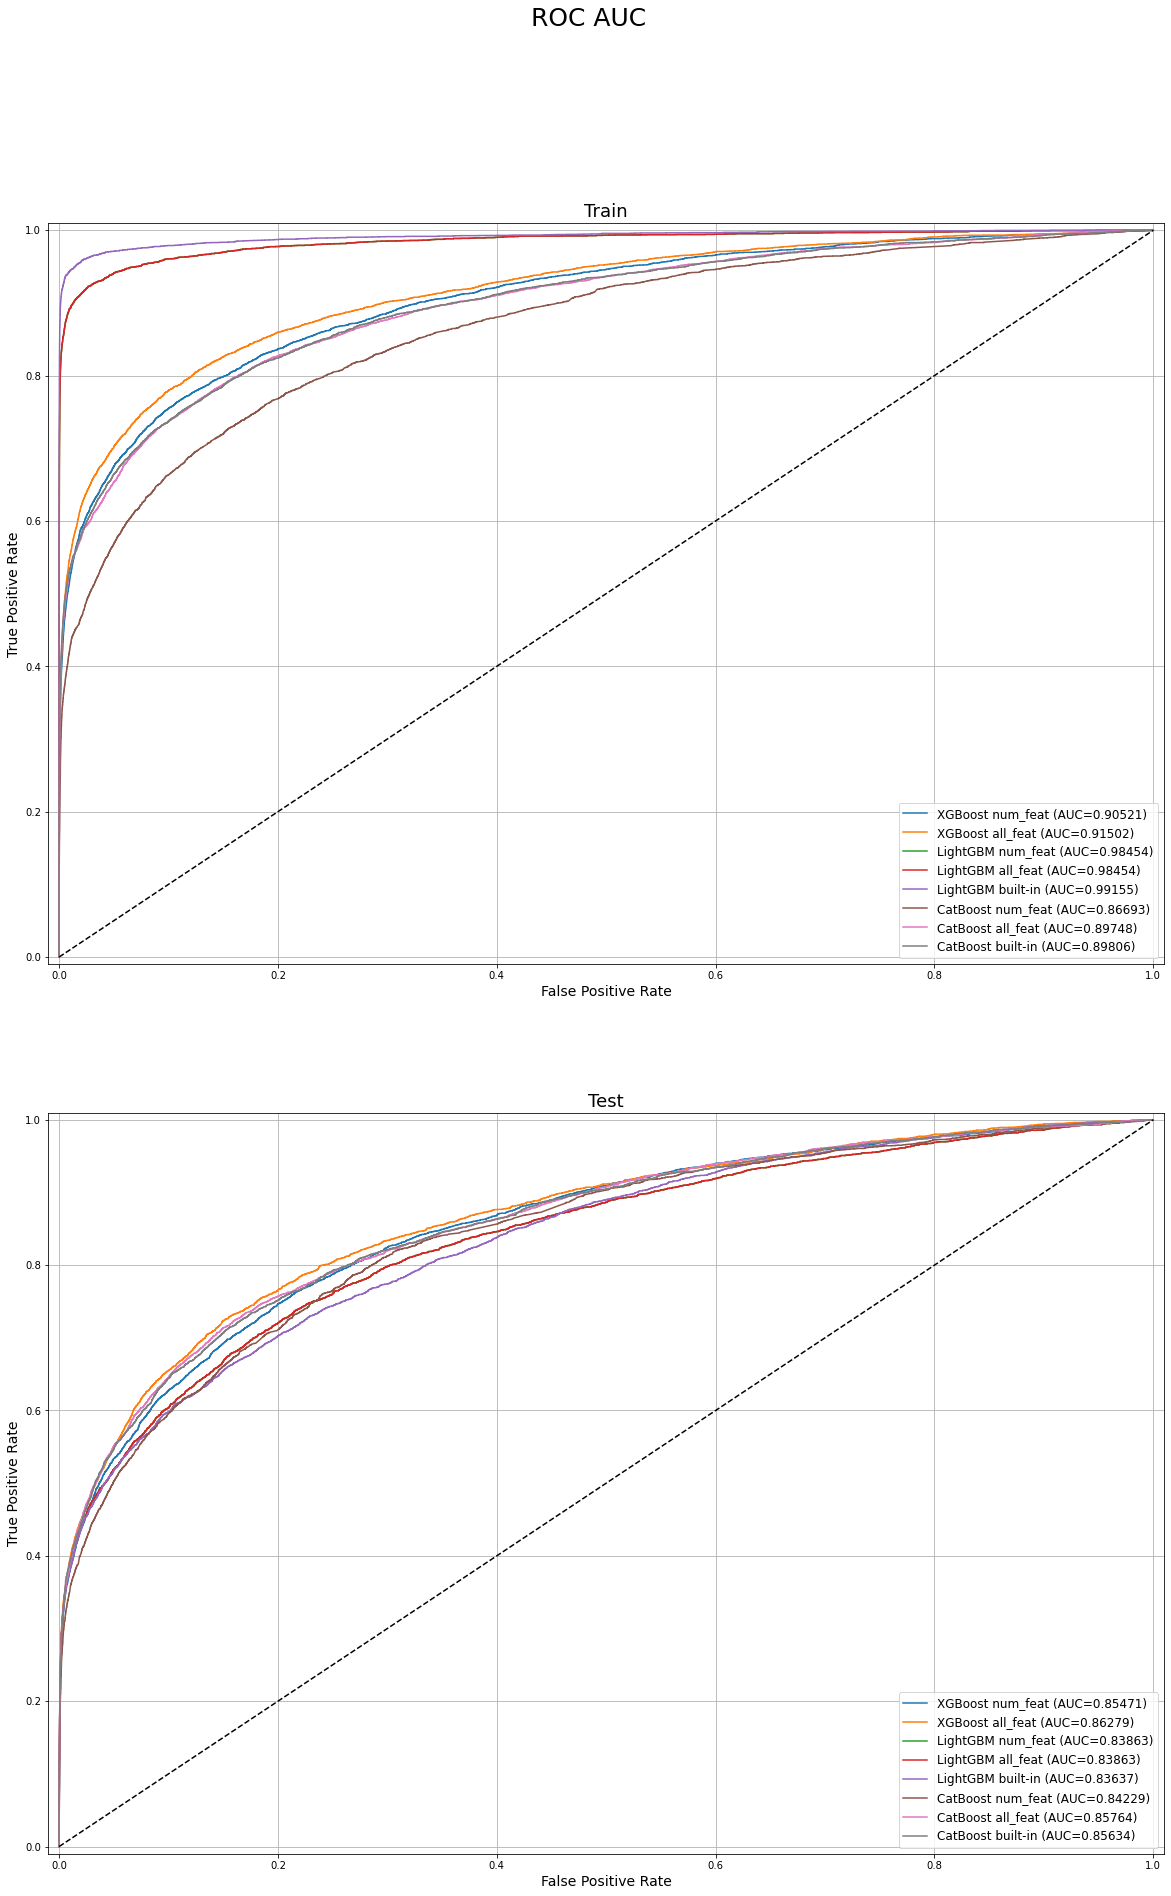

In [43]:
true_train = train[target].values
true_test = test[target].values

fig, axs = plt.subplots(2, 1, figsize=(20, 30))

fpr, tpr, _ = roc_curve(true_test, prob_xgb_test)
axs[1].plot(fpr, tpr, label=f'XGBoost num_feat (AUC={auc(fpr, tpr):.5f})')

fpr, tpr, _ = roc_curve(true_train, prob_xgb_train)
axs[0].plot(fpr, tpr, label=f'XGBoost num_feat (AUC={auc(fpr, tpr):.5f})')

fpr, tpr, _ = roc_curve(true_test, prob_xgb_test_cat)
axs[1].plot(fpr, tpr, label=f'XGBoost all_feat (AUC={auc(fpr, tpr):.5f})')

fpr, tpr, _ = roc_curve(true_train, prob_xgb_train_cat)
axs[0].plot(fpr, tpr, label=f'XGBoost all_feat (AUC={auc(fpr, tpr):.5f})')


fpr, tpr, _ = roc_curve(true_test, prob_lgb_test)
axs[1].plot(fpr, tpr, label=f'LightGBM num_feat (AUC={auc(fpr, tpr):.5f})')

fpr, tpr, _ = roc_curve(true_train, prob_lgb_train)
axs[0].plot(fpr, tpr, label=f'LightGBM num_feat (AUC={auc(fpr, tpr):.5f})')

fpr, tpr, _ = roc_curve(true_test, prob_lgb_test_cat)
axs[1].plot(fpr, tpr, label=f'LightGBM all_feat (AUC={auc(fpr, tpr):.5f})')

fpr, tpr, _ = roc_curve(true_train, prob_lgb_train_cat)
axs[0].plot(fpr, tpr, label=f'LightGBM all_feat (AUC={auc(fpr, tpr):.5f})')

fpr, tpr, _ = roc_curve(true_test, prob_lgb_test_cat_s)
axs[1].plot(fpr, tpr, label=f'LightGBM built-in (AUC={auc(fpr, tpr):.5f})')

fpr, tpr, _ = roc_curve(true_train, prob_lgb_train_cat_s)
axs[0].plot(fpr, tpr, label=f'LightGBM built-in (AUC={auc(fpr, tpr):.5f})')


fpr, tpr, _ = roc_curve(true_test, prob_cb_test[:, 1])
axs[1].plot(fpr, tpr, label=f'CatBoost num_feat (AUC={auc(fpr, tpr):.5f})')

fpr, tpr, _ = roc_curve(true_train, prob_cb_train[:, 1])
axs[0].plot(fpr, tpr, label=f'CatBoost num_feat (AUC={auc(fpr, tpr):.5f})')

fpr, tpr, _ = roc_curve(true_test, prob_cb_test_cat[:, 1])
axs[1].plot(fpr, tpr, label=f'CatBoost all_feat (AUC={auc(fpr, tpr):.5f})')

fpr, tpr, _ = roc_curve(true_train, prob_cb_train_cat[:, 1])
axs[0].plot(fpr, tpr, label=f'CatBoost all_feat (AUC={auc(fpr, tpr):.5f})')

fpr, tpr, _ = roc_curve(true_test, prob_cb_test_cat_s[:, 1])
axs[1].plot(fpr, tpr, label=f'CatBoost built-in (AUC={auc(fpr, tpr):.5f})')

fpr, tpr, _ = roc_curve(true_train, prob_cb_train_cat_s[:, 1])
axs[0].plot(fpr, tpr, label=f'CatBoost built-in (AUC={auc(fpr, tpr):.5f})')

for i in range(2):
    axs[i].plot([0, 1], [0, 1], 'k--')
    axs[i].set_xlim([-0.01, 1.01])
    axs[i].set_ylim([-0.01, 1.01])
    axs[i].set_xlabel('False Positive Rate', fontsize=14)
    axs[i].set_ylabel('True Positive Rate', fontsize=14)
    axs[i].grid()
    axs[i].legend(loc='lower right', fontsize='large')

axs[0].set_title('Train', fontsize=18)
axs[1].set_title('Test', fontsize=18)
fig.suptitle('ROC AUC', fontsize=25)
plt.show()

Все модели дают близкие результаты на тестовой выборке. Использование категориальных признаков собственной обработки в одних моделях дает небольшой прирост метрики AUC, в других - не дает результата. Правильная предобработка выборок и тонкая настройка гиперпараметров позволит улучшить качество модели и более эффективно использовать категориальные переменные для обучения.
По качеству на обучающей выборке видно, что XGBoost и LightGBM более подвержены переобчению, и использование категориальных признаков его усиливает. CatBoost более стабилен, хоть и показывает результаты немного ниже. Использование кросс валидации позволит снизить переобучение.

In [44]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


__Задание на повторение:__

__Задание 1:__ _Построить график распределения времени совершения транзакции для обучающей / тестовой выборки, сделать выводы о том, как разбиты данные и какие виды валидации могут подойти для данной задачи._

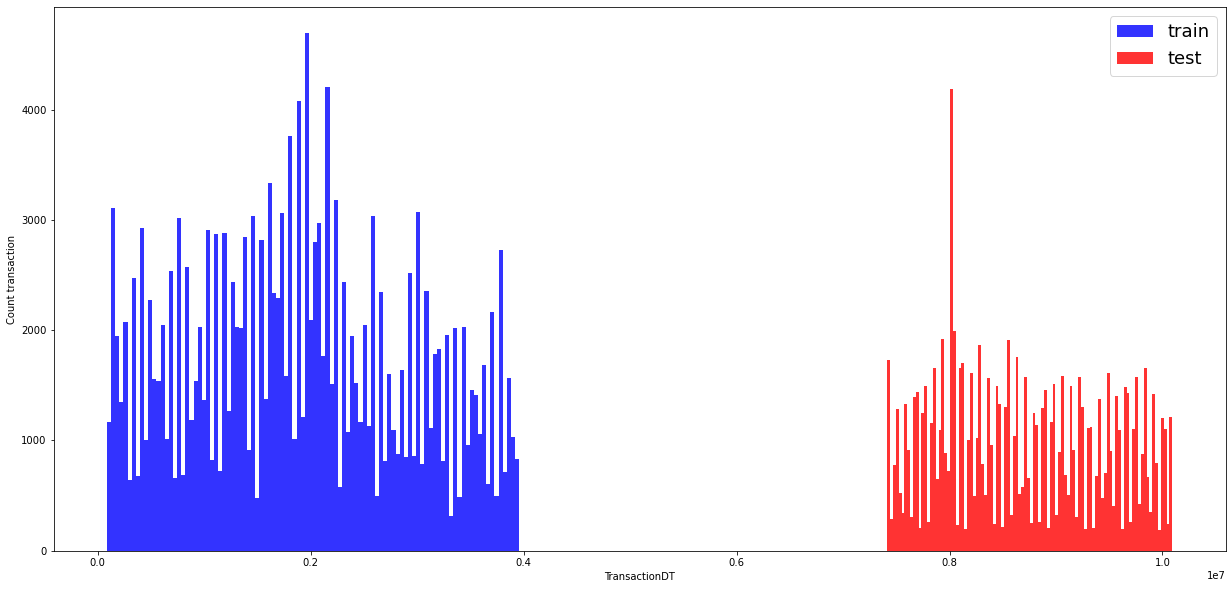

In [45]:
fig = plt.figure(figsize=(21, 10))

plt.hist(train["TransactionDT"], bins=100, color="blue", alpha=0.8, label="train")
plt.hist(test["TransactionDT"], bins=100, color="red", alpha=0.8, label="test")
plt.xlabel("TransactionDT")
plt.ylabel("Count transaction")
plt.legend(fontsize=18);

Данные представляют собой временные ряды и разбиты они по времени, причем train и test разнесены по разным временным периодам. Для данной выборки подойдет cross-validation on a rolling basis.

__Задание 2:__ _построить scatter-plot зависимости суммы транзакции от времени совершения транзакции. Построить графики для обучающей выборки и для тестовой выборки, для обучающей выборки - построить как для целевой переменной = 0, так и для переменной = 1. Сделать выводы._

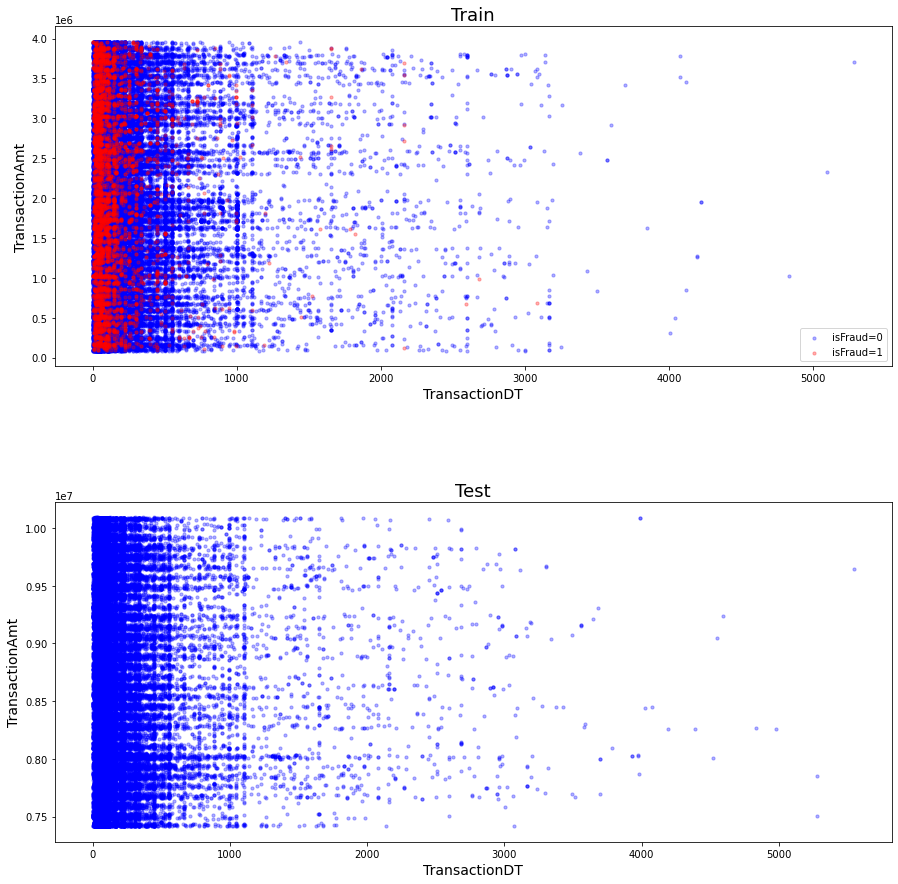

In [46]:
S_SIZE = 10
ALPHA = 0.3

fig, axs = plt.subplots(2, 1, figsize=(15, 15))

axs[0].scatter(x=train[train["isFraud"]==0]["TransactionAmt"],
               y=train[train["isFraud"]==0]["TransactionDT"], 
               s=S_SIZE,
               alpha=ALPHA, 
               color="b", 
               label="isFraud=0")

axs[0].scatter(x=train[train["isFraud"]==1]["TransactionAmt"],
               y=train[train["isFraud"]==1]["TransactionDT"], 
               s=S_SIZE,
               alpha=ALPHA, 
               color="r", 
               label="isFraud=1")

axs[0].set_ylabel("TransactionAmt", size=14)
axs[0].set_xlabel("TransactionDT", size=14)
axs[0].legend()
axs[0].set_title("Train", size=18)

axs[1].scatter(x=test["TransactionAmt"], y=test["TransactionDT"], s=S_SIZE, alpha=ALPHA, color="b")
axs[1].set_ylabel("TransactionAmt", size=14)
axs[1].set_xlabel("TransactionDT", size=14)
axs[1].set_title("Test", size=18)

plt.subplots_adjust(wspace=0.3, hspace=0.4)

Зависимость суммы транзакции от времени ее совершения распределена не равномерно. Также наблюдается дисбаланс классов.

__Задание 3:__ _построить распределение признака TransactionAmt в логарифмическом масштабе, сделать выводы о близости распредления к нормальному распределению. Построить распределение признака в логарифмическому масштабе для обучающей выборк и для тестовой выборки, сделать выводы._

In [47]:
import scipy.stats as st

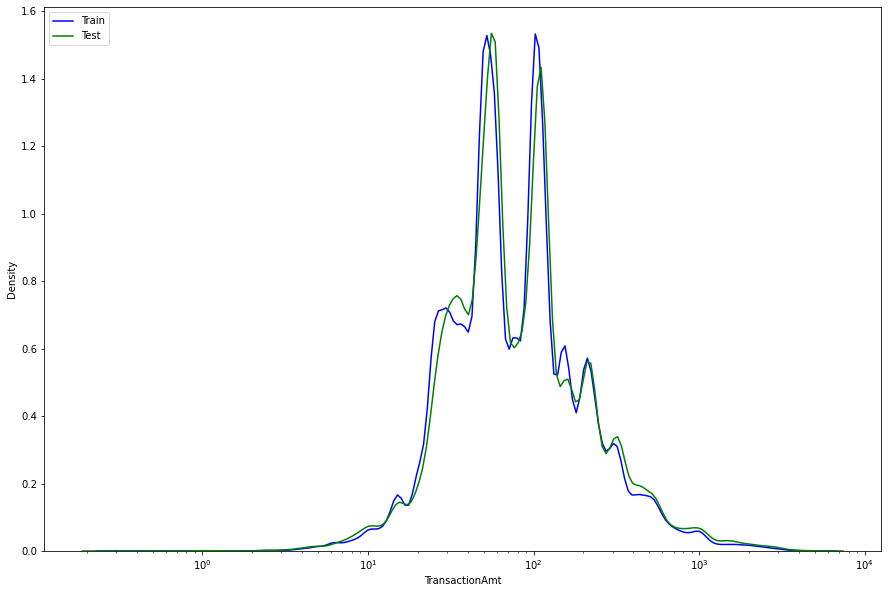

In [48]:
target_pl = "TransactionAmt"
fig = plt.figure(figsize=(15, 10))

sns.kdeplot(train[target_pl], color="blue", log_scale=True, label="Train")
sns.kdeplot(test[target_pl], color="green", log_scale=True, label="Test")
plt.legend(loc='upper left');

Распределения признака TransactionAmt для test и train близки, и они не распределены по нормальному закону.

__Задание 4:__ _построить распределение признака целевой переменной в зависимости от значений категориальных признаков ProductCD, card4, card6. Сделать выводы._

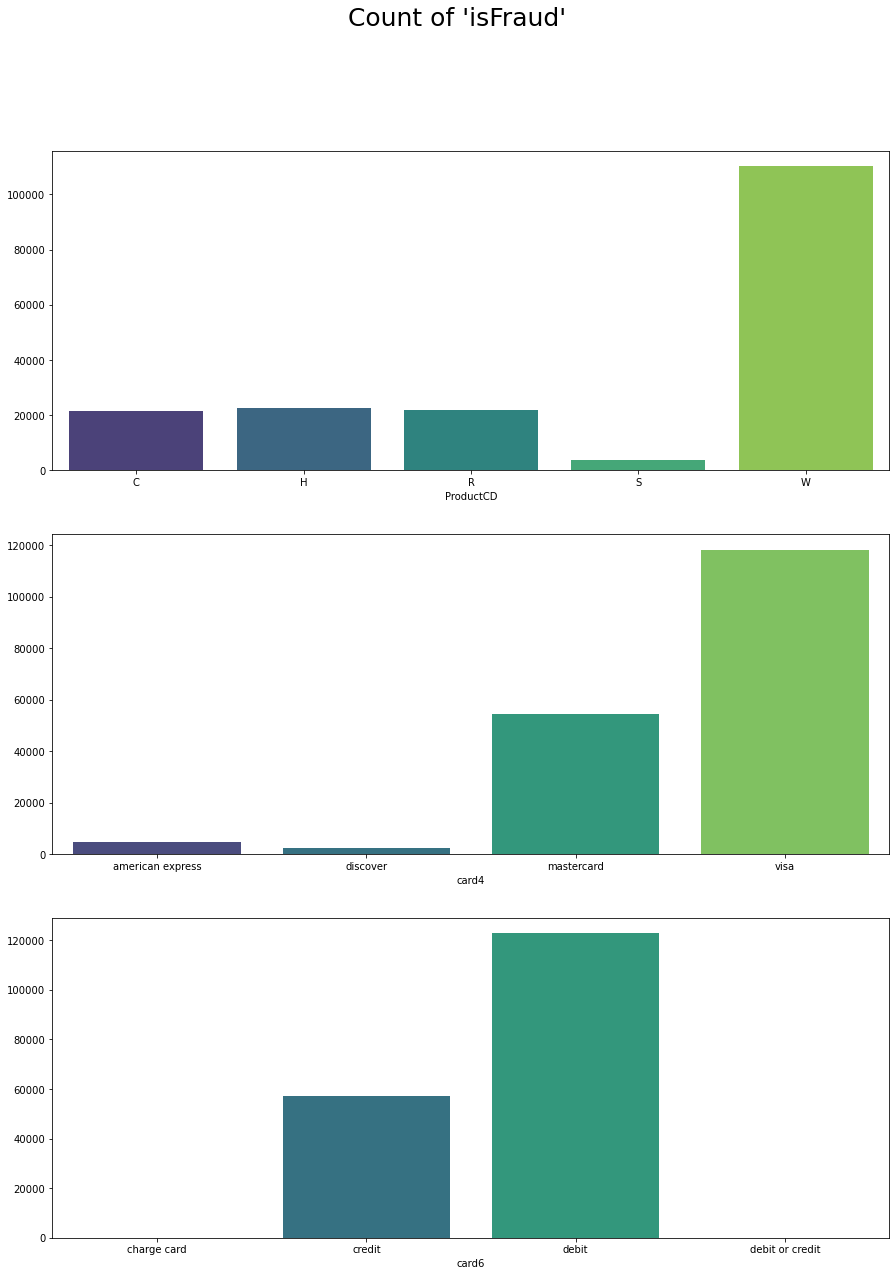

In [49]:
fig, axes = plt.subplots(3, 1, figsize=(15, 20))

for num, feature in enumerate(["ProductCD", "card4", "card6"]):
    data = train.copy()
    statistics = data.groupby([feature])["isFraud"].count()

    sns.barplot(
        x=statistics.index,
        y=statistics.values,
        palette="viridis",
        ax=axes[num]
    )
fig.suptitle("Count of 'isFraud'", fontsize=25);

Наблюдается сильный дисбаланс. Категориальные признаки сильно коррелируют с целевой переменной. Некоторые классы категориальных переменных отсутствуют в наблюдениях с целевой переменной равной 1.